In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [17]:
#Function to train models
#Based on Homework 4 and pytorch tutorial for building a cifar classifier

def train_model(net, loss_fn, batchsize, trainset, valset, optimizer, num_epochs):

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

    valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize,
                                         shuffle=False, num_workers=2)
    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []
    
    N = num_epochs
    net = net.cuda()
    loss_fn = loss_fn.cuda()

    for epoch in range(N):  # loop over the dataset multiple times
        correct = 0.0
        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, _, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            max_scores, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item()
            if (i+1) % (20) == 0:    # print every 10 mini-batches
                print('Train: [%d, %5d] loss: %.3f Accuracy: %.4f' %
                      (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
                running_loss = 0.0
        
        train_accuracies.append(correct / len(trainset))
        train_losses.append(running_loss / (i + 1))  

        net.eval()
        correct = 0
        running_loss = 0
        for i, data in enumerate(valloader, 0):
            inputs, labels, _, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)
            running_loss += loss_fn(outputs, labels).item()

            max_scores, max_labels = outputs.max(1)
            correct += (max_labels == labels).sum().item()

        print('Validation: [%d, %5d] loss: %.3f Accuracy: %.4f' % 
              (epoch + 1, i + 1, running_loss / i+1, correct / ((i+1)*batchsize)))
        
        val_accuracies.append(correct / len(valset))
        val_losses.append(running_loss / (i + 1))
            

    print('Finished Training')

In [3]:
import torch.utils.data
import json, os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Class for our Dataset
class UVaBuildinglabel(torch.utils.data.Dataset):
    def __init__(self, image_path, annotation_filepath, transform = None):
        super(UVaBuildinglabel, self).__init__()
        
        print('Loading data...')
        data = pd.read_csv(annotation_filepath)              #json.load(open(annotation_filepath, 'rb'))
        
        self.transform = transforms.Compose(
        [transforms.Resize(320),  # 1. Resize smallest side to 256.
        transforms.RandomCrop(320), # 2. Crop random square of 224x224 pixels.
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
        
        self.image_path = image_path    # storing image path. 
        
        
        # get the image pixel values and labels
        image_ids = data.iloc[:, 0 ]
        label_ids = data.iloc[:, 1]
        label_names = data.iloc[:, 2]

        self.image_ids = data.iloc[:, 0 ] #[img_name for (img_id, img_name) in paired_id_names]
        self.image_labels = data.iloc[:, 1]   #[img_id for (img_id, img_name) in paired_id_names]
        self.image_classes= data.iloc[:, 2]


        print(image_ids[0])
        print(label_ids[0])
        print(label_names)

        
    def __getitem__(self, index):
        image_name = self.image_ids[index]
        img_ = Image.open(open(os.path.join(self.image_path, image_name), 'rb'))
        img_ = img_.convert("RGB")
        if self.transform:
            img_ = self.transform(img_)
        label_ = self.image_labels[index]
        class_name= self.image_classes[index]
        return img_, label_,image_name,class_name
    
    def __len__(self):
        return len(self.image_ids)
       
      
# You can unnormalize the transformation of torch's transforms.normalize 
# with this custom transformation.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


trainset = UVaBuildinglabel('../DATA', '../DATA/DATA1trainSet.csv')
valset = UVaBuildinglabel('../DATA', '../DATA/DATA1valSet.csv')

Loading data...
alderman1.jpg
0
0      Alderman Library
1      Alderman Library
2      Alderman Library
3      Alderman Library
4      Alderman Library
             ...       
409       Wilsdorf Hall
410       Wilsdorf Hall
411       Wilsdorf Hall
412       Wilsdorf Hall
413       Wilsdorf Hall
Name: name, Length: 414, dtype: object
Loading data...
alderman9.jpg
0
0     Alderman Library
1     Alderman Library
2     Alderman Library
3     Alderman Library
4          Alumni Hall
            ...       
88       Wilsdorf Hall
89       Wilsdorf Hall
90       Wilsdorf Hall
91       Wilsdorf Hall
92       Wilsdorf Hall
Name: name, Length: 93, dtype: object


In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
resnetPretrained = models.resnet50(pretrained = True)
resnetPretrained.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(resnetPretrained.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(resnetPretrained, loss_fn, 4, trainset, valset, optimizer, 5)

Train: [1,    20] loss: 6.871 Accuracy: 0.0375
Train: [1,    40] loss: 3.220 Accuracy: 0.0375
Train: [1,    60] loss: 2.132 Accuracy: 0.0583
Train: [1,    80] loss: 1.783 Accuracy: 0.0813
Train: [1,   100] loss: 1.592 Accuracy: 0.1100
Validation: [1,    24] loss: 3.582 Accuracy: 0.4271
Train: [2,    20] loss: 3.718 Accuracy: 0.2750
Train: [2,    40] loss: 2.244 Accuracy: 0.2812
Train: [2,    60] loss: 1.835 Accuracy: 0.2708
Train: [2,    80] loss: 1.576 Accuracy: 0.3000
Train: [2,   100] loss: 1.399 Accuracy: 0.3275
Validation: [2,    24] loss: 2.576 Accuracy: 0.7292
Train: [3,    20] loss: 3.109 Accuracy: 0.4375
Train: [3,    40] loss: 1.886 Accuracy: 0.5375
Train: [3,    60] loss: 1.506 Accuracy: 0.5958
Train: [3,    80] loss: 1.359 Accuracy: 0.6188
Train: [3,   100] loss: 1.293 Accuracy: 0.6175
Validation: [3,    24] loss: 1.968 Accuracy: 0.7500
Train: [4,    20] loss: 2.270 Accuracy: 0.7625
Train: [4,    40] loss: 1.515 Accuracy: 0.7937
Train: [4,    60] loss: 1.398 Accuracy: 0.800

In [6]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
resnetPretrained = models.resnet50(pretrained = True)
resnetPretrained.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(resnetPretrained.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(resnetPretrained, loss_fn, 4, trainset, valset, optimizer, 5)

Train: [1,    20] loss: 6.764 Accuracy: 0.0625
Train: [1,    40] loss: 3.184 Accuracy: 0.0563
Train: [1,    60] loss: 2.199 Accuracy: 0.0708
Train: [1,    80] loss: 1.800 Accuracy: 0.0844
Train: [1,   100] loss: 1.596 Accuracy: 0.1025
Validation: [1,    24] loss: 3.553 Accuracy: 0.4271
Train: [2,    20] loss: 3.721 Accuracy: 0.3125
Train: [2,    40] loss: 2.247 Accuracy: 0.3125
Train: [2,    60] loss: 1.814 Accuracy: 0.3083
Train: [2,    80] loss: 1.548 Accuracy: 0.3438
Train: [2,   100] loss: 1.432 Accuracy: 0.3625
Validation: [2,    24] loss: 2.721 Accuracy: 0.5417
Train: [3,    20] loss: 2.852 Accuracy: 0.5875
Train: [3,    40] loss: 1.870 Accuracy: 0.6062
Train: [3,    60] loss: 1.594 Accuracy: 0.5958
Train: [3,    80] loss: 1.395 Accuracy: 0.6000
Train: [3,   100] loss: 1.300 Accuracy: 0.6125
Validation: [3,    24] loss: 1.951 Accuracy: 0.8125
Train: [4,    20] loss: 2.283 Accuracy: 0.7500
Train: [4,    40] loss: 1.678 Accuracy: 0.7312
Train: [4,    60] loss: 1.413 Accuracy: 0.745

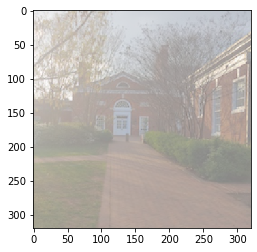

GroundTruth:  ('Newcomb Hall',)
Predicted:  North Grounds Gym


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

classes = ['Alderman Library', 'Alumni Hall', 'Aquatic & Fitness Center', 'Chemical Engineering Building', 'John Paul Jones Arena', 
           'Law School Building', 'Mechanical Building', 'Memorial Gym', 'Monroe Hall', 
           'Newcomb Hall', 'North Grounds Gym', 'Old Cabell Hall', 'Olsson Hall', 
           'Physics Building', 'Rice Hall', 'The Rotunda', 'Scott Stadium', 'Slaughter Recreation',
           'Thornton Hall', 'Wilsdorf Hall']

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#do some predictions
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = resnetPretrained(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [12]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = resnetPretrained(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

resnetPretrainedAccuracy = open('../results/accuracy/resnetPretrainedAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    resnetPretrainedAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
resnetPretrainedAccuracy.close()  

resnetPretrainedConfusion = open('../results/confusion/resnetPretrainedConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    resnetPretrainedConfusion.write(line)
resnetPretrainedConfusion.close()

accuracy for  Alderman Library is :  0.75
accuracy for  Alumni Hall is :  1.0
accuracy for  Aquatic & Fitness Center is :  0.800000011920929
accuracy for  Chemical Engineering Building is :  0.800000011920929
accuracy for  John Paul Jones Arena is :  0.800000011920929
accuracy for  Law School Building is :  1.0
accuracy for  Mechanical Building is :  1.0
accuracy for  Memorial Gym is :  1.0
accuracy for  Monroe Hall is :  0.75
accuracy for  Newcomb Hall is :  0.5
accuracy for  North Grounds Gym is :  1.0
accuracy for  Old Cabell Hall is :  1.0
accuracy for  Olsson Hall is :  1.0
accuracy for  Physics Building is :  1.0
accuracy for  Rice Hall is :  1.0
accuracy for  The Rotunda is :  1.0
accuracy for  Scott Stadium is :  1.0
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  1.0
accuracy for  Wilsdorf Hall is :  1.0


In [13]:
loss_fn = nn.CrossEntropyLoss()
mobilenetPretrained = models.mobilenet_v2(pretrained=True)
mobilenetPretrained.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(mobilenetPretrained.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(mobilenetPretrained, loss_fn, 4, trainset, valset, optimizer, 5)

Train: [1,    20] loss: 9.468 Accuracy: 0.0125
Train: [1,    40] loss: 3.335 Accuracy: 0.1313
Train: [1,    60] loss: 2.102 Accuracy: 0.2208
Train: [1,    80] loss: 1.579 Accuracy: 0.3000
Train: [1,   100] loss: 1.359 Accuracy: 0.3450
Validation: [1,    24] loss: 2.782 Accuracy: 0.6771
Train: [2,    20] loss: 2.214 Accuracy: 0.7000
Train: [2,    40] loss: 1.575 Accuracy: 0.6687
Train: [2,    60] loss: 1.455 Accuracy: 0.6500
Train: [2,    80] loss: 1.232 Accuracy: 0.6656
Train: [2,   100] loss: 1.216 Accuracy: 0.6700
Validation: [2,    24] loss: 1.837 Accuracy: 0.8021
Train: [3,    20] loss: 1.789 Accuracy: 0.8375
Train: [3,    40] loss: 1.280 Accuracy: 0.8562
Train: [3,    60] loss: 1.208 Accuracy: 0.8542
Train: [3,    80] loss: 1.110 Accuracy: 0.8562
Train: [3,   100] loss: 1.083 Accuracy: 0.8675
Validation: [3,    24] loss: 1.305 Accuracy: 0.9271
Train: [4,    20] loss: 1.401 Accuracy: 0.8875
Train: [4,    40] loss: 1.179 Accuracy: 0.8938
Train: [4,    60] loss: 1.093 Accuracy: 0.900

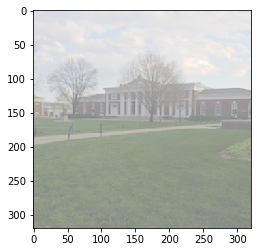

GroundTruth:  ('Old Cabell Hall',)
Predicted:  Old Cabell Hall


In [16]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenetPretrained(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [17]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = mobilenetPretrained(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

mobilenetPretrainedAccuracy = open('../results/accuracy/mobilenetPretrainedAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    mobilenetPretrainedAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
mobilenetPretrainedAccuracy.close()  

mobilenetPretrainedConfusion = open('../results/confusion/mobilenetPretrainedConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    mobilenetPretrainedConfusion.write(line)
mobilenetPretrainedConfusion.close()

accuracy for  Alderman Library is :  1.0
accuracy for  Alumni Hall is :  1.0
accuracy for  Aquatic & Fitness Center is :  1.0
accuracy for  Chemical Engineering Building is :  1.0
accuracy for  John Paul Jones Arena is :  0.800000011920929
accuracy for  Law School Building is :  0.8333333134651184
accuracy for  Mechanical Building is :  1.0
accuracy for  Memorial Gym is :  1.0
accuracy for  Monroe Hall is :  1.0
accuracy for  Newcomb Hall is :  1.0
accuracy for  North Grounds Gym is :  1.0
accuracy for  Old Cabell Hall is :  1.0
accuracy for  Olsson Hall is :  1.0
accuracy for  Physics Building is :  1.0
accuracy for  Rice Hall is :  1.0
accuracy for  The Rotunda is :  1.0
accuracy for  Scott Stadium is :  1.0
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  1.0
accuracy for  Wilsdorf Hall is :  1.0


In [20]:
loss_fn = nn.CrossEntropyLoss()
alexnetPretrained = models.alexnet(pretrained=True)
alexnetPretrained.classifier[6] = nn.Linear(4096, len(trainset.image_classes))
optimizer = optim.SGD(alexnetPretrained.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-5)
#optimizer = optim.SGD(resnet.parameters(), lr=1e-4, momentum=0.9)

train_model(alexnetPretrained, loss_fn, 4, trainset, valset, optimizer, 5)

Train: [1,    20] loss: 6.412 Accuracy: 0.0500
Train: [1,    40] loss: 2.650 Accuracy: 0.1187
Train: [1,    60] loss: 1.828 Accuracy: 0.1792
Train: [1,    80] loss: 1.517 Accuracy: 0.2375
Train: [1,   100] loss: 1.502 Accuracy: 0.2500
Validation: [1,    24] loss: 2.498 Accuracy: 0.5625
Train: [2,    20] loss: 2.345 Accuracy: 0.6625
Train: [2,    40] loss: 1.623 Accuracy: 0.6438
Train: [2,    60] loss: 1.357 Accuracy: 0.6500
Train: [2,    80] loss: 1.325 Accuracy: 0.6281
Train: [2,   100] loss: 1.270 Accuracy: 0.6200
Validation: [2,    24] loss: 2.377 Accuracy: 0.5938
Train: [3,    20] loss: 2.042 Accuracy: 0.7375
Train: [3,    40] loss: 1.602 Accuracy: 0.6813
Train: [3,    60] loss: 1.386 Accuracy: 0.6833
Train: [3,    80] loss: 1.218 Accuracy: 0.6875
Train: [3,   100] loss: 1.188 Accuracy: 0.6925
Validation: [3,    24] loss: 1.894 Accuracy: 0.7083
Train: [4,    20] loss: 1.571 Accuracy: 0.8000
Train: [4,    40] loss: 1.316 Accuracy: 0.8063
Train: [4,    60] loss: 1.220 Accuracy: 0.795

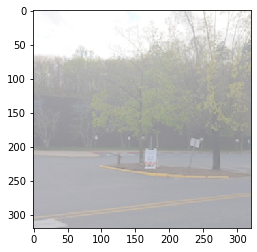

GroundTruth:  ('Slaughter Recreation',)
Predicted:  Slaughter Recreation


In [22]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = alexnetPretrained(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [23]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = alexnetPretrained(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

alexnetPretrainedAccuracy = open('../results/accuracy/alexnetPretrainedAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    alexnetPretrainedAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
alexnetPretrainedAccuracy.close()  

alexnetPretrainedConfusion = open('../results/confusion/alexnetPretrainedConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    alexnetPretrainedConfusion.write(line)
alexnetPretrainedConfusion.close()

accuracy for  Alderman Library is :  1.0
accuracy for  Alumni Hall is :  1.0
accuracy for  Aquatic & Fitness Center is :  0.800000011920929
accuracy for  Chemical Engineering Building is :  0.4000000059604645
accuracy for  John Paul Jones Arena is :  0.800000011920929
accuracy for  Law School Building is :  1.0
accuracy for  Mechanical Building is :  1.0
accuracy for  Memorial Gym is :  0.3333333432674408
accuracy for  Monroe Hall is :  0.5
accuracy for  Newcomb Hall is :  0.5
accuracy for  North Grounds Gym is :  1.0
accuracy for  Old Cabell Hall is :  1.0
accuracy for  Olsson Hall is :  1.0
accuracy for  Physics Building is :  1.0
accuracy for  Rice Hall is :  1.0
accuracy for  The Rotunda is :  0.6000000238418579
accuracy for  Scott Stadium is :  1.0
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  1.0
accuracy for  Wilsdorf Hall is :  1.0


In [26]:
loss_fn = nn.CrossEntropyLoss()

resnet = models.resnet50()
resnet.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(resnet.parameters(), lr=5e-4, momentum=0.9)

train_model(resnet, loss_fn, 4, trainset, valset, optimizer, 30)

Train: [1,    20] loss: 6.355 Accuracy: 0.0500
Train: [1,    40] loss: 3.045 Accuracy: 0.0563
Train: [1,    60] loss: 2.265 Accuracy: 0.0625
Train: [1,    80] loss: 1.913 Accuracy: 0.0594
Train: [1,   100] loss: 1.740 Accuracy: 0.0550
Validation: [1,    24] loss: 5.263 Accuracy: 0.0521
Train: [2,    20] loss: 4.806 Accuracy: 0.0250
Train: [2,    40] loss: 2.858 Accuracy: 0.0625
Train: [2,    60] loss: 2.238 Accuracy: 0.0667
Train: [2,    80] loss: 1.890 Accuracy: 0.0656
Train: [2,   100] loss: 1.707 Accuracy: 0.0625
Validation: [2,    24] loss: 5.857 Accuracy: 0.1042
Train: [3,    20] loss: 5.152 Accuracy: 0.0500
Train: [3,    40] loss: 2.787 Accuracy: 0.0375
Train: [3,    60] loss: 2.189 Accuracy: 0.0500
Train: [3,    80] loss: 1.918 Accuracy: 0.0563
Train: [3,   100] loss: 1.691 Accuracy: 0.0600
Validation: [3,    24] loss: 4.627 Accuracy: 0.1146
Train: [4,    20] loss: 4.413 Accuracy: 0.0500
Train: [4,    40] loss: 2.757 Accuracy: 0.0437
Train: [4,    60] loss: 2.197 Accuracy: 0.045

Train: [29,    40] loss: 2.054 Accuracy: 0.4750
Train: [29,    60] loss: 1.543 Accuracy: 0.4875
Train: [29,    80] loss: 1.538 Accuracy: 0.4688
Train: [29,   100] loss: 1.320 Accuracy: 0.4750
Validation: [29,    24] loss: 3.509 Accuracy: 0.4896
Train: [30,    20] loss: 2.546 Accuracy: 0.5000
Train: [30,    40] loss: 1.932 Accuracy: 0.4938
Train: [30,    60] loss: 1.593 Accuracy: 0.5042
Train: [30,    80] loss: 1.508 Accuracy: 0.4625
Train: [30,   100] loss: 1.343 Accuracy: 0.4725
Validation: [30,    24] loss: 3.208 Accuracy: 0.4167
Finished Training


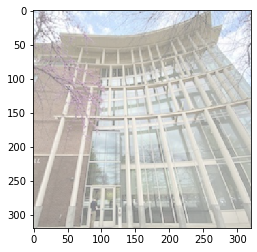

GroundTruth:  ('Rice Hall',)
Predicted:  Rice Hall


In [30]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = resnet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [31]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = resnet(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

resnetAccuracy = open('../results/accuracy/resnetAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    resnetAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
resnetAccuracy.close()  

resnetConfusion = open('../results/confusion/resnetConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    resnetConfusion.write(line)
resnetConfusion.close()

accuracy for  Alderman Library is :  0.0
accuracy for  Alumni Hall is :  0.0
accuracy for  Aquatic & Fitness Center is :  0.0
accuracy for  Chemical Engineering Building is :  0.4000000059604645
accuracy for  John Paul Jones Arena is :  0.20000000298023224
accuracy for  Law School Building is :  0.3333333432674408
accuracy for  Mechanical Building is :  0.4000000059604645
accuracy for  Memorial Gym is :  0.3333333432674408
accuracy for  Monroe Hall is :  0.5
accuracy for  Newcomb Hall is :  0.0
accuracy for  North Grounds Gym is :  0.0
accuracy for  Old Cabell Hall is :  0.0
accuracy for  Olsson Hall is :  1.0
accuracy for  Physics Building is :  0.6000000238418579
accuracy for  Rice Hall is :  0.6666666865348816
accuracy for  The Rotunda is :  0.800000011920929
accuracy for  Scott Stadium is :  0.25
accuracy for  Slaughter Recreation is :  1.0
accuracy for  Thornton Hall is :  1.0
accuracy for  Wilsdorf Hall is :  0.4000000059604645


In [33]:
loss_fn = nn.CrossEntropyLoss()
mobilenet = models.mobilenet_v2()
mobilenet.fc = nn.Linear(2048, len(trainset.image_classes))
optimizer = optim.SGD(mobilenet.parameters(), lr=5e-4, momentum=0.9)

train_model(mobilenet, loss_fn, 4, trainset, valset, optimizer, 30)

Train: [1,    20] loss: 8.044 Accuracy: 0.0250
Train: [1,    40] loss: 4.002 Accuracy: 0.0500
Train: [1,    60] loss: 2.760 Accuracy: 0.0500
Train: [1,    80] loss: 2.150 Accuracy: 0.0437
Train: [1,   100] loss: 1.812 Accuracy: 0.0400
Validation: [1,    24] loss: 4.942 Accuracy: 0.0625
Train: [2,    20] loss: 4.746 Accuracy: 0.0500
Train: [2,    40] loss: 2.767 Accuracy: 0.0563
Train: [2,    60] loss: 2.144 Accuracy: 0.0458
Train: [2,    80] loss: 1.837 Accuracy: 0.0469
Train: [2,   100] loss: 1.652 Accuracy: 0.0550
Validation: [2,    24] loss: 4.305 Accuracy: 0.0729
Train: [3,    20] loss: 4.270 Accuracy: 0.1125
Train: [3,    40] loss: 2.631 Accuracy: 0.0688
Train: [3,    60] loss: 2.038 Accuracy: 0.0792
Train: [3,    80] loss: 1.787 Accuracy: 0.0844
Train: [3,   100] loss: 1.653 Accuracy: 0.0725
Validation: [3,    24] loss: 4.159 Accuracy: 0.0833
Train: [4,    20] loss: 4.247 Accuracy: 0.0750
Train: [4,    40] loss: 2.553 Accuracy: 0.0688
Train: [4,    60] loss: 2.043 Accuracy: 0.062

Train: [29,    40] loss: 1.925 Accuracy: 0.5125
Train: [29,    60] loss: 1.571 Accuracy: 0.5208
Train: [29,    80] loss: 1.461 Accuracy: 0.4938
Train: [29,   100] loss: 1.335 Accuracy: 0.4750
Validation: [29,    24] loss: 2.606 Accuracy: 0.5417
Train: [30,    20] loss: 2.568 Accuracy: 0.5625
Train: [30,    40] loss: 1.897 Accuracy: 0.4813
Train: [30,    60] loss: 1.588 Accuracy: 0.4667
Train: [30,    80] loss: 1.496 Accuracy: 0.4500
Train: [30,   100] loss: 1.343 Accuracy: 0.4550
Validation: [30,    24] loss: 2.535 Accuracy: 0.5208
Finished Training


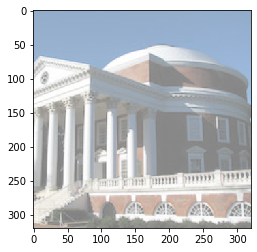

GroundTruth:  ('The Rotunda',)
Predicted:  Old Cabell Hall


In [35]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = mobilenet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [36]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = mobilenet(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

mobilenetAccuracy = open('../results/accuracy/mobilenetAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    mobilenetAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
mobilenetAccuracy.close()  

mobilenetConfusion = open('../results/confusion/mobilenetConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    mobilenetConfusion.write(line)
mobilenetConfusion.close()

accuracy for  Alderman Library is :  1.0
accuracy for  Alumni Hall is :  0.0
accuracy for  Aquatic & Fitness Center is :  0.4000000059604645
accuracy for  Chemical Engineering Building is :  0.20000000298023224
accuracy for  John Paul Jones Arena is :  0.6000000238418579
accuracy for  Law School Building is :  0.3333333432674408
accuracy for  Mechanical Building is :  0.800000011920929
accuracy for  Memorial Gym is :  1.0
accuracy for  Monroe Hall is :  0.0
accuracy for  Newcomb Hall is :  0.0
accuracy for  North Grounds Gym is :  0.75
accuracy for  Old Cabell Hall is :  0.6000000238418579
accuracy for  Olsson Hall is :  0.0
accuracy for  Physics Building is :  1.0
accuracy for  Rice Hall is :  1.0
accuracy for  The Rotunda is :  0.0
accuracy for  Scott Stadium is :  0.25
accuracy for  Slaughter Recreation is :  0.800000011920929
accuracy for  Thornton Hall is :  1.0
accuracy for  Wilsdorf Hall is :  0.20000000298023224


In [37]:
loss_fn = nn.CrossEntropyLoss()
alexnet = models.alexnet()
alexnet.classifier[6] = nn.Linear(4096, len(trainset.image_classes))
optimizer = optim.SGD(alexnet.parameters(), lr=5e-4, momentum=0.9)

train_model(alexnet, loss_fn, 4, trainset, valset, optimizer, 30)

Train: [1,    20] loss: 7.340 Accuracy: 0.0125
Train: [1,    40] loss: 4.085 Accuracy: 0.0375
Train: [1,    60] loss: 3.038 Accuracy: 0.0375
Train: [1,    80] loss: 2.519 Accuracy: 0.0531
Train: [1,   100] loss: 2.211 Accuracy: 0.0500
Validation: [1,    24] loss: 7.250 Accuracy: 0.0625
Train: [2,    20] loss: 7.303 Accuracy: 0.0625
Train: [2,    40] loss: 4.066 Accuracy: 0.0563
Train: [2,    60] loss: 3.024 Accuracy: 0.0583
Train: [2,    80] loss: 2.510 Accuracy: 0.0594
Train: [2,   100] loss: 2.203 Accuracy: 0.0675
Validation: [2,    24] loss: 7.207 Accuracy: 0.0625
Train: [3,    20] loss: 7.258 Accuracy: 0.0250
Train: [3,    40] loss: 4.045 Accuracy: 0.0250
Train: [3,    60] loss: 3.008 Accuracy: 0.0250
Train: [3,    80] loss: 2.497 Accuracy: 0.0312
Train: [3,   100] loss: 2.188 Accuracy: 0.0525
Validation: [3,    24] loss: 7.120 Accuracy: 0.0625
Train: [4,    20] loss: 7.133 Accuracy: 0.0750
Train: [4,    40] loss: 3.886 Accuracy: 0.0625
Train: [4,    60] loss: 2.427 Accuracy: 0.054

Train: [29,    40] loss: 2.276 Accuracy: 0.1812
Train: [29,    60] loss: 1.837 Accuracy: 0.1875
Train: [29,    80] loss: 1.670 Accuracy: 0.1969
Train: [29,   100] loss: 1.495 Accuracy: 0.2050
Validation: [29,    24] loss: 3.542 Accuracy: 0.2188
Train: [30,    20] loss: 3.533 Accuracy: 0.2250
Train: [30,    40] loss: 2.125 Accuracy: 0.2500
Train: [30,    60] loss: 1.898 Accuracy: 0.2083
Train: [30,    80] loss: 1.636 Accuracy: 0.2031
Train: [30,   100] loss: 1.514 Accuracy: 0.1925
Validation: [30,    24] loss: 3.585 Accuracy: 0.2500
Finished Training


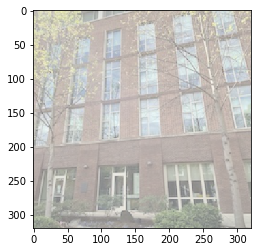

GroundTruth:  ('Rice Hall',)
Predicted:  Rice Hall


In [39]:
#do some predictions
trainsetLoader = DataLoader(trainset, shuffle=True)
valsetLoader = DataLoader(valset, shuffle=True)

dataiter = iter(valsetLoader)
images, labels, image_name, class_name = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', class_name)

images = images.cuda()
output = alexnet(images)
_, predicted = torch.max(output, 1)

print('Predicted: ', classes[predicted.item()])

In [40]:
no_classes = 20

confusion_matrix = torch.zeros(no_classes, no_classes)

valsetLoader = DataLoader(valset, shuffle=True)
dataiter = iter(valsetLoader)

for i in range(len(valset)):
    images, labels, image_name, class_name = dataiter.next()
    
    images = images.cuda()
    output = alexnet(images)
    _, predicted = torch.max(output,1)
    
    confusion_matrix[labels.long(), predicted.long()] += 1
    

#print(confusion_matrix)
conf_matrix=confusion_matrix.diag()/confusion_matrix.sum(1)
#print(confusion_matrix.diag()/confusion_matrix.sum(1))

alexnetAccuracy = open('../results/accuracy/alexnetAccuracy.csv', 'w')
for i in range(0, 20):
    print("accuracy for ", classes[i], "is : ", conf_matrix[i].item())
    alexnetAccuracy.write(classes[i]+","+str(conf_matrix[i].item())+"\n")
alexnetAccuracy.close()  

alexnetConfusion = open('../results/confusion/alexnetConfusion.csv', 'w')
for item in confusion_matrix/confusion_matrix.sum(1):
    line = ""
    for item1 in item:
        line+=str(item1.item())+","
    line = line[:-1]+"\n"
    alexnetConfusion.write(line)
alexnetConfusion.close()

accuracy for  Alderman Library is :  0.5
accuracy for  Alumni Hall is :  0.0
accuracy for  Aquatic & Fitness Center is :  0.0
accuracy for  Chemical Engineering Building is :  0.0
accuracy for  John Paul Jones Arena is :  0.0
accuracy for  Law School Building is :  0.0
accuracy for  Mechanical Building is :  0.20000000298023224
accuracy for  Memorial Gym is :  0.0
accuracy for  Monroe Hall is :  0.0
accuracy for  Newcomb Hall is :  0.0
accuracy for  North Grounds Gym is :  0.5
accuracy for  Old Cabell Hall is :  0.6000000238418579
accuracy for  Olsson Hall is :  0.4000000059604645
accuracy for  Physics Building is :  0.20000000298023224
accuracy for  Rice Hall is :  0.6666666865348816
accuracy for  The Rotunda is :  0.0
accuracy for  Scott Stadium is :  0.0
accuracy for  Slaughter Recreation is :  0.6000000238418579
accuracy for  Thornton Hall is :  0.4000000059604645
accuracy for  Wilsdorf Hall is :  0.0
